#Consideraciones generales sobre sobre el modelo de predicción de la esclerometría

# Introducción

La esclerometría es el ensayo no destructivo más sencillo y barato existente hoy para estimar la calidad resistente de elementos de hormigón elaborado, sin embargo, su baja presición en lo que a predicciones de resistencia respecta, lo convierte en un método poco confiable. En el presente trabajo, desarrollaré conceptos claves para mejorar la estimación de la predicción de la resistencia basado en un estudio del modelo con el cual esas predicciones son realizadas (regresion lineal), como así también otorgar la idea de intervalo de confianza para realizar los reportes para incluir rigor estadistico al modelo.
Además, propondré un modelo alternativo para mejorar la performance de este ensayo, incluyendo una mayor cantidad de variables al análisis.
Para todo lo anterior, realizaré una calibración de esclerometro haciendo uso del lenguaje Python como herramienta de análisis. De todas formas, las conclusiones alcanzadas son independientes de la herramienta que se utilice para procesar los datos.

# Primera Parte: Calibración convencional y sus limitaciones.

Malhotra y Carino en su libro "Handbook on Nondestructive Testing of Concrete" establecen los siguientes pasos para el procedimiento de calibración (correlación):


1.   Preparar una cantidad de probetas de 15 por 30 centímetros que estén en el rango de los hormigones que se buscará ensayar. Usar el mismo cemento y los mismos áridos. Respetar el curado de las probetas y realizarlo el mismo período de tiempo que los elementos estructurales que se ensayaran.
Aquí radica una de las primeras debilidades del método, por lo menos en lo que respecta a la construcción en Argentina. Practicamente ninguna estructura de hormigón se cura, salvo en casos especiales por requisitos específicos de los comitentes.
2.   Luego de aplicado el procedimiento de encabezado correspondiente, colocar la probeta en la prensa y aplicar un 15 % de la carga ultima de rotura del elemento. Asegurarse de que el elemento se encuentra en condición saturado a superficie seca.
3. Realizar 15 lecturas del rebote, 5 en 3 lineas verticales separadas a 120º. Evitar ensayar el mismo lugar dos veces (pueden aparecer algunas lecturas herraticas que pueden ser descatardas mediante los procedimientos detallados en las diferentes normativas sobre este ensayo) (la normativa Argentina establece 9 rebotes por ensayo, valor que fue utilizado para la calibración realizada en este trabajo).
4. Obtener el promedio de las lecturas y tomar este valor como el resultado de la medición esclerométrica.
5. Repetir este procedimiento con todas las probetas.
7. Ensayar luego la probeta hasta la compresion y graficar el numero de rebote contra la resistencia a 28 días de la probeta.
8. Obtener una curva de regresión que permita establecer una relación entre el número de rebote y la resistencia.  

En este procedimiento esta incompleto en mi opinión. Hay que agregarle una etapa más de validación del método de correlación, tal como se desarrollará en este trabajo. Como más adelante detallaré, es importante definir el limite minimo de probetas a utilizar para realizar la calibración de forma tal que el error que se realice en la lectura sea el mínimo posible en base a las verdaderas limitaciones del metodo y no a posibles errores en el proceso de calibración del aparato. Con esto quiero decir que se debe medir la performance del método (en este trabajo utilizaremos el factor R2 y RMSE) y se debe verificar que esta performance se mantenga aún en valores que el proceso de correlación nunca haya visto (este proceso consiste en separar las muestras utilizadas para la calibracion en una porcion que se utilice realmente para realizar la regresion lineal y en otra para medir la performance de esta regresión: train set y test set).





In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sns.set_style("dark")

file_path = "/content/drive/MyDrive/Calibracion Esclerometro/Calibración esclerómetro.csv"

dataset = pd.read_csv(file_path)

X = dataset.iloc[:, -2:-1].values
y = dataset.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_trainpred = regressor.predict(X_train)
y_pred = regressor.predict(X_test)
    
print("Training set score: {:.2f}".format(regressor.score(X_train, y_train)))
print("Test set score: {:.2f}".format(regressor.score(X_test, y_test)))

line_mse_train = mean_squared_error(y_train, y_trainpred)
line_mse_train = np.sqrt(line_mse_train)

line_mse_test = mean_squared_error(y_test, y_pred)
line_mse_test = np.sqrt(line_mse_test)

print("The mean squared error for the train set is:" + str(line_mse_train))
print("The mean squared error for the test set is:" + str(line_mse_test))

from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, X_train, y_train, cv=4)
print("Cross-validation scores: {}".format(scores))
print("Mean of scores: ", scores.mean())
print("Standar deviation of scores: ", scores.std())

Training set score: 0.81
Test set score: 0.77
The mean squared error for the train set is:3.3601608116210264
The mean squared error for the test set is:4.669578130164337
Cross-validation scores: [0.84608938 0.84579803 0.6721004  0.81055611]
Mean of scores:  0.793635979037187
Standar deviation of scores:  0.07164046812255921


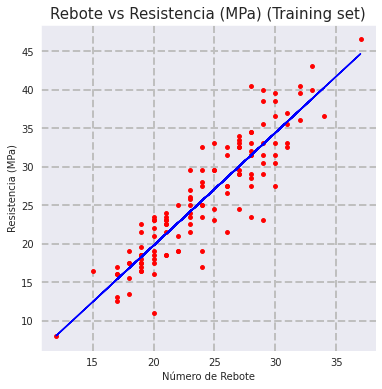

In [104]:
plt.figure(figsize = (6,6))
plt.scatter(X_train, y_train, s = 15., color = 'red')
plt.plot(X_train, regressor.predict(X_train), color = 'blue')
plt.title('Rebote vs Resistencia (MPa) (Training set)', fontsize = 15)
plt.xlabel('Número de Rebote')
plt.ylabel('Resistencia (MPa)')
plt.grid(True, lw = 2, ls = '--', c = '.75')
plt.autumn()
plt.show();


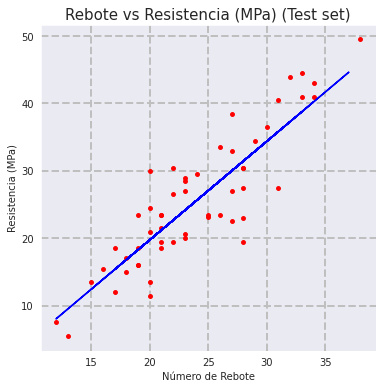

In [103]:

plt.figure(figsize = (6,6))    
plt.scatter(X_test, y_test, s = 15., color = 'red')
plt.plot(X_train, regressor.predict(X_train), color = 'blue')
plt.title('Rebote vs Resistencia (MPa) (Test set)', fontsize = 15)
plt.xlabel('Número de Rebote')
plt.ylabel('Resistencia (MPa)')
plt.grid(True, lw = 2, ls = '--', c = '.75')
plt.autumn()
plt.show();

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


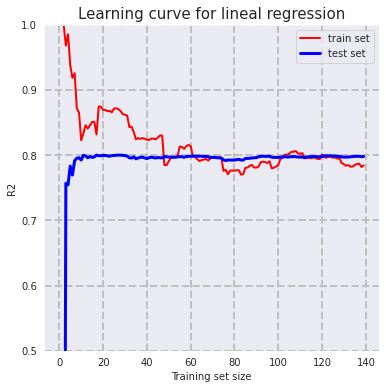

In [98]:
def plot_learning_curve2(model, X, y):
    X_trainlc, X_val, y_trainlc, y_val = train_test_split(X, y, test_size= 0.2, random_state= 14)
    trainlc_errors, val_errors = [], []
    for m in range(1,len(X_trainlc)):
        model.fit(X_trainlc[:m], y_trainlc[:m])
        y_trainlc_predict = model.predict(X_trainlc[:m])
        y_val_predict = model.predict(X_val)
        trainlc_errors.append(r2_score( y_trainlc[:m], y_trainlc_predict))
        val_errors.append(r2_score(y_val, y_val_predict))
    plt.plot(trainlc_errors,"r-", linewidth=2, label="train set")
    plt.plot(val_errors, "b-", linewidth=3, label="test set")
    
plt.figure(figsize =(6,6))
plot_learning_curve2(regressor, X, y)
plt.title('Learning curve for lineal regression', fontsize = 15)
plt.xlabel('Training set size')
plt.ylabel('R2')
plt.grid(True, lw = 2, ls = '--', c = '.75')
plt.ylim([0.5, 1])
plt.legend()
plt.autumn()
plt.show();

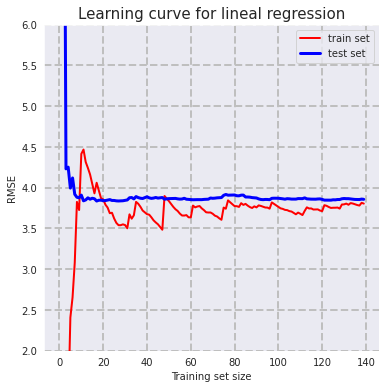

In [101]:

from sklearn.metrics import mean_squared_error

def plot_learning_curve(model, X, y):
    X_trainlc, X_val, y_trainlc, y_val = train_test_split(X, y, test_size= 0.2, random_state = 14)
    trainlc_errors, val_errors = [], []
    for m in range(1,len(X_trainlc)):
        model.fit(X_trainlc[:m], y_trainlc[:m])
        y_trainlc_predict = model.predict(X_trainlc[:m])
        y_val_predict = model.predict(X_val)
        trainlc_errors.append(mean_squared_error(y_trainlc_predict, y_trainlc[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(trainlc_errors),"r-", linewidth=2, label="train set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="test set")
    
plt.figure(figsize = (6,6))
plot_learning_curve(regressor, X, y)
plt.title('Learning curve for lineal regression', fontsize = 15)
plt.xlabel('Training set size')
plt.ylabel('RMSE')
plt.grid(True, lw = 2, ls = '--', c = '.75')
plt.ylim([2, 6])
plt.legend()
plt.autumn()
plt.show();

In [5]:
residual_linearmodel_train = [y_train - y_trainpred]
residual_linearmodel_test = [y_test - y_pred]

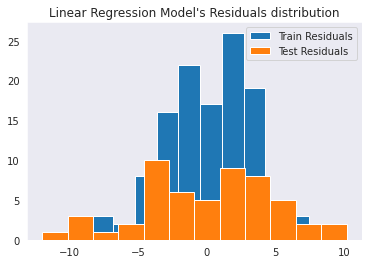

In [58]:
plt.hist(residual_linearmodel_train, label ="Train Residuals", bins =12)
plt.hist(residual_linearmodel_test, label ="Test Residuals", bins =12)
plt.title("Linear Regression Model's Residuals distribution")
plt.legend()
plt.show();

Como puede apreciarse en lo gráficos anteriores, existe una consideración muy importante a la hora de realizar la calibración del esclerómetro por el modo convencional (regresión lineal) que ninguna referencia bibliográfica parece establecer, y es que se debe verificar que la performance del modelo (ya sea medida por R2 o por RSME) converja y así poder garantizar que nuestro modelo generalice adecuadamente (comprendiendo las limitaciones naturales del método esclerométrico, que para este trabajo parecen estar en promedio en 0,8022 con un desvio de 0,0570).
Otra cuestión importante que vale la pena aclarar es que la distribucion de los residuos, es decir la diferencia entre el valor que nuestra medicion predice y el real, posee una distribución normal con un ligero sesgo, tal como se puede apreciar en la figura.

En lo que respecta al error medio cuadrático, parece ser que el método de verificación del modelo nos indica que este converge en 3,80. Esto quiere decir que en el error que es de esperarse que suceda con mayor frecuencia estará alrededor de los 3,8 MPa. Con esta afirmación, y en función del análisis anteriormente descripto, de ser utilizada la regresión lineal como método de calibración del dispositvo, los resultados de la esclerometría deberian ser presentados como intervalos de resistencia en donde se informe el promedio de las lecturas +/- el valor de la convergencia del RMSE (en nuestro casi +/- 3,8 MPa). 

Otro comentario al respecto de este análisis que vale la pena aclarar es que si la calibración se realiza con un número bajo de muestras (con poca variedades resistentes de hormigón), los valores de R2 o de RMSE no será confiables ya que estarán por sobre (o por debajo en el caso del error) de lo que verdaderamente arrojará el método en el campo, haciendo que las predicciones que hagamos a partir de sus lectores posean errores muy superiores a los que el método bien calibrado nos permitiría obtener.



# Segunda Parte: Nueva propuesta de calibración

# Random Forest modelling

Habiendo establecido las limitaciones del método, se probaron diferentes tipos de regresión multivariable en donde se busco incorporar una mayor cantidad de información, tal como se verá más adelante, para intentar mejorar la performance de la predicción de la resistencia. De todos los modelos probados el que mejor resultado dió fue el de random forest. 
A continuación se define el modelo y los gráficos de la evolución de las medidas de precision que miden la performance del modelo.

In [7]:
dataset.columns

Index(['TMN', 'As. Obj.', 'Especificada', 'Tenor', 'Paston', 'Cemento', 'Edad',
       'Rebote', 'Rotura'],
      dtype='object')

In [8]:
# Random Forest Regression

X_alternativo = dataset[['TMN', 'As. Obj.', 'Especificada', 'Tenor', 'Paston', 'Cemento', 'Edad', 'Rebote']]
y_alternativo = dataset.Rotura

X_alternativo = pd.get_dummies(X_alternativo, columns= ['TMN', 'As. Obj.', 'Especificada','Paston', 'Cemento'])

X_alternativo

,Tenor,Edad,Rebote,TMN_12,TMN_19,TMN_25,TMN_30,As. Obj._5.0,As. Obj._8.0,As. Obj._12.5,As. Obj._18.0,Especificada_13,Especificada_17,Especificada_21,Especificada_25,Especificada_30,Especificada_35,Paston_No,Paston_Si,Cemento_Avellaneda,Cemento_Holcim,Cemento_Loma Negra
0,300,28,23,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0
1,300,10,27,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
2,300,7,23,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3,322,28,27,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
4,322,28,28,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,260,28,23,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1
173,300,28,27,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
174,300,28,28,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
175,340,8,26,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0


In [25]:

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_alternativo, y_alternativo, test_size = 0.20)

# Training the Random Forest Regression model on the whole dataset
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train_rf, y_train_rf)

# Predicting the Test set results
y_pred_train_rf = rf_regressor.predict(X_train_rf)
y_pred_rf = rf_regressor.predict(X_test_rf)
np.set_printoptions(precision=2)
#print(np.concatenate((y_pred_rf.reshape(len(y_pred_rf),1), y_test_rf.reshape(len(y_test_rf),1)),1))

# Evaluating the Model Performance
from sklearn.metrics import r2_score
print("R2 for train set for random forest model:", r2_score(y_train_rf, y_pred_train_rf))
print("R2 for test set for random fores model:", r2_score(y_test_rf, y_pred_rf))


R2 for train set for random forest model: 0.97309485951447
R2 for test set for random fores model: 0.877867402665315


Como puede observarse, el modelo de random forest mejoró considerablemente en el valor de R2 para predecir la resistencia. Esto no solo se debe a la mayor capacidad del modelo seleccionado sino también a la inclusión de más información para lograr dicha predicción.
Al momento de elegir que datos extra poner en el proceso de calibración, se optó por elegir parámetros que pudiesen ser obtenidos sobre el elemento ensayado, y no datos que dificilmente se puedan encontrar como el asentamiento que poseía el hormigón en el sector que fue ensayado por el esclerómetro. Con esto en mente, el nuevo modelo incluyó el tamaño máximo nominal, el asentamiento de consigna, la resistencia especificada, si el hormigón para calibrar el esclerómetro provenia de un pastón de laboratorio o no, el tipo de cemento utilizado (para la calibración se utilizaron probetas de 3 cementos diferentes, pero en esta parte cabe destacar que una de las debilidades de este trabajo es que en las probetas utilizadas para la calibración la gran mayoría eran de un solo tipo de cemento, por lo que la base de datos no estaba debidamente balanceada, cuestión que quedará para un futuro trabajo), el tenor cemento, la edad de la probeta y el rebote.

In [116]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X_alternativo, y_alternativo)

features = X_alternativo.columns
feature_mutual_information = pd.Series(mi, index= features)
feature_mutual_information = feature_mutual_information.sort_values(ascending=False)
feature_mutual_information


Rebote                0.701140
Tenor                 0.443123
Paston_Si             0.238266
Paston_No             0.233568
Edad                  0.179675
Especificada_21       0.171388
As. Obj._18.0         0.153542
Especificada_30       0.143703
As. Obj._12.5         0.102384
TMN_12                0.080279
Cemento_Holcim        0.079170
TMN_19                0.047240
TMN_30                0.045864
Especificada_35       0.036669
Cemento_Avellaneda    0.034822
As. Obj._8.0          0.031026
Cemento_Loma Negra    0.015602
Especificada_25       0.012636
Especificada_17       0.010156
Especificada_13       0.008611
As. Obj._5.0          0.000000
TMN_25                0.000000
dtype: float64

Existen diferentes formas de estimar la capacidad que posee un parámetro de aportar valor al modelo. En el caso de relaciones lineales esta capacidad puede medirse calculando la covarianza entre el valor utilizado para predecir y el valor predecido. 

En nuestro trabajo utilizaremos otro tipo de función para medir la utilidad que aporta cada parámetro en nuestro proceso de predicción llamada información mutua (mutual information). Esta métrica es muy similar a la correlación en el sentido en el que mide la relación que existe entre dos variables, pero a diferencia de la correlación, puede detectar relaciones no lineales. 

En si la información mutua consiste en cuanto de incertidumbre sobre una variable se puede reducir al tener información sobre otra variable. El menor valor posible que puede tomar esta medida es cero, y cuando esto sucede se considera que las dos varibles son independientes. 

Como se puede observar en los resultados anteriores, el valor que mayor indice de mi arroja es el del rebote, como cabia de esperarse. Pero además, el tenor y la edad también son posibles fuentes para reducir la incertidumbre asociada a la predicción de la resistencia.


In [27]:
importances = rf_regressor.feature_importances_
forest_importances = pd.Series(importances ,index = ["TMN 19", "TMN 12", "TMN 30", "TMN 25", "As 12,5", "As 8", "As 18", "As 5", 
                                                    "Esp 21", "Esp 30", "Esp 17", "Esp 13", "Esp 25", "Esp 35",
                                                    "No es Paston", "Si es Paston", 'Avellaneda', 'Loma Negra', 'Holcim',
                                                    "Tenor", "Edad", "Rebote"])
print(forest_importances)

TMN 19          0.077962
TMN 12          0.085482
TMN 30          0.779869
TMN 25          0.005304
As 12,5         0.005517
As 8            0.000000
As 18           0.005938
As 5            0.001512
Esp 21          0.002131
Esp 30          0.003556
Esp 17          0.002214
Esp 13          0.005084
Esp 25          0.002283
Esp 35          0.004082
No es Paston    0.002214
Si es Paston    0.002195
Avellaneda      0.000481
Loma Negra      0.001517
Holcim          0.001420
Tenor           0.005237
Edad            0.003143
Rebote          0.002860
dtype: float64


Otra posible medición sobre la utilidad de un parámetro para aportar valor al modelo viene dada por la función feature importances del modelo de random forest. Esta medida también arroja que el parámetro más significativo es el del rebote, seguido por la edad y el tenor cemento, tal como los resultados encontrados por la medición de información mutua.

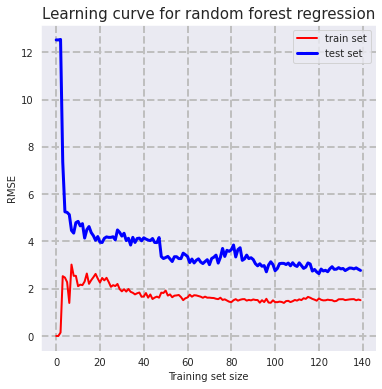

In [119]:
from sklearn.metrics import mean_squared_error
 
plt.figure(figsize=(6,6))
plot_learning_curve(rf_regressor, X_alternativo, y_alternativo)
plt.title('Learning curve for random forest regression' , fontsize = 15)
plt.xlabel('Training set size')
plt.ylabel('RMSE')
plt.grid(True, lw = 2, ls = '--', c = '.75')
plt.legend()
plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


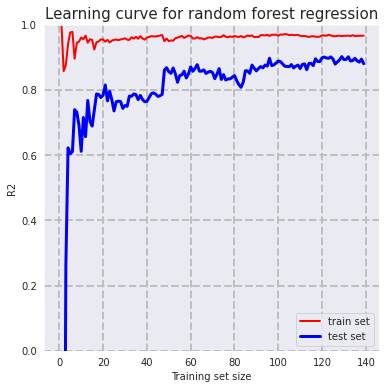

In [123]:

plt.figure(figsize=(6,6))
plot_learning_curve2(rf_regressor, X_alternativo, y_alternativo)
plt.title('Learning curve for random forest regression', fontsize = 15)
plt.xlabel('Training set size')
plt.ylabel('R2')
plt.ylim([0,1])
plt.grid(True, lw = 2, ls = '--', c = '.75')
plt.legend()
plt.show();

In [120]:
# See how the model accuracy evolve



from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_regressor, X_train_rf, y_train_rf, cv=5)

def display_scores(scores):
    print("R2 para varios test set:", scores)
    print("Media de R2:", scores.mean())
    print("Desvio Estandar de R2:", scores.std())
    
display_scores(scores)

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 40, 50], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 30, 40, 50], 'max_features': [2, 3, 4, 6, 8]},
]

grid_search = GridSearchCV(rf_regressor, param_grid, cv = 5, scoring = "neg_mean_squared_error")
grid_search.fit(X_train_rf, y_train_rf)


grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
print(grid_search.best_params_)


R2 para varios test set: [0.83 0.81 0.82 0.87 0.86]
Media de R2: 0.8355256031622001
Desvio Estandar de R2: 0.02466883791026767
4.1174423132268805 {'max_features': 2, 'n_estimators': 3}
3.935141969795403 {'max_features': 2, 'n_estimators': 10}
3.8193698093109014 {'max_features': 2, 'n_estimators': 30}
3.671644036424663 {'max_features': 2, 'n_estimators': 40}
3.586066173285008 {'max_features': 2, 'n_estimators': 50}
4.068577430826242 {'max_features': 4, 'n_estimators': 3}
3.9779386808012487 {'max_features': 4, 'n_estimators': 10}
3.5527843092699265 {'max_features': 4, 'n_estimators': 30}
3.5193654568754758 {'max_features': 4, 'n_estimators': 40}
3.5621132413977334 {'max_features': 4, 'n_estimators': 50}
3.7128176149804815 {'max_features': 6, 'n_estimators': 3}
3.442839054581048 {'max_features': 6, 'n_estimators': 10}
3.386287548310094 {'max_features': 6, 'n_estimators': 30}
3.3977201803847947 {'max_features': 6, 'n_estimators': 40}
3.474248894270511 {'max_features': 6, 'n_estimators': 50

In [29]:
rf_regressor_optimo = RandomForestRegressor(max_features= 6, n_estimators = 50)
rf_regressor_optimo.fit(X_train_rf, y_train_rf)

# Predicting the Test set results
y_pred_train_rf_optimo = rf_regressor_optimo.predict(X_train_rf)
y_pred_rf_optimo = rf_regressor_optimo.predict(X_test_rf)
np.set_printoptions(precision=2)

# Evaluating the Model Performance
from sklearn.metrics import r2_score
print("R2 for train set for random forest model:", r2_score(y_train_rf, y_pred_train_rf_optimo))
print("R2 for test set for random fores model:", r2_score(y_test_rf, y_pred_rf_optimo))

R2 for train set for random forest model: 0.9717950232318607
R2 for test set for random fores model: 0.8699982373058583


# XGBOOST Modelling

In [44]:
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth = 5, min_child_weight = 1, gamma = 10, subsample = 0.5, objective= "reg:squarederror")
xgb_regressor.fit(X_train_rf, y_train_rf,
                  early_stopping_rounds=4, 
                  eval_set=[(X_test_rf, y_test_rf)],
                  verbose=False)

# Predicting the Test set results
y_pred_train_xgb = xgb_regressor.predict(X_train_rf)
y_pred_xgb = xgb_regressor.predict(X_test_rf)
np.set_printoptions(precision=2)

# Evaluating the Model Performance

print("R2 for train set for XGBoost model:", r2_score(y_train_rf, y_pred_train_xgb))
print("R2 for test set for XGBoost model:", r2_score(y_test_rf, y_pred_xgb))

R2 for train set for XGBoost model: 0.9318884684396331
R2 for test set for XGBoost model: 0.8825100447398865


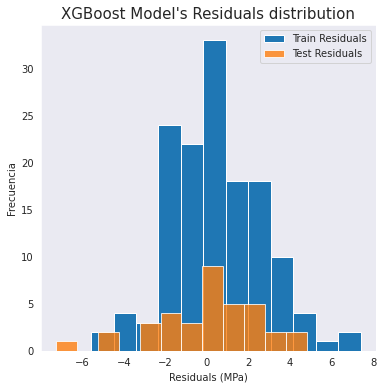

In [113]:
residual_xgboostmodel_train = [y_train_rf - y_pred_train_xgb]
residual_xgboostmodel_test = [y_test_rf - y_pred_xgb]

plt.figure(figsize =(6,6))
plt.hist(residual_xgboostmodel_train, label ="Train Residuals", bins =12)
plt.hist(residual_xgboostmodel_test, label ="Test Residuals", bins =12, alpha = 0.8)
plt.title("XGBoost Model's Residuals distribution", fontsize = 15)
plt.xlabel("Residuals (MPa)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show();


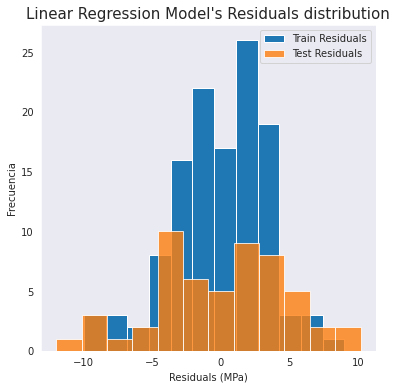

In [112]:
plt.figure(figsize =(6,6))
plt.hist(residual_linearmodel_train, label ="Train Residuals", bins =12)
plt.hist(residual_linearmodel_test, label ="Test Residuals", bins =12, alpha = 0.8)
plt.title("Linear Regression Model's Residuals distribution", fontsize = 15)
plt.xlabel("Residuals (MPa)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show();

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


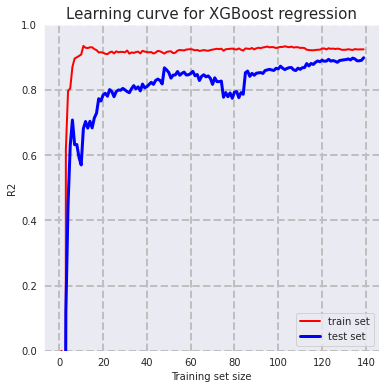

In [122]:
plt.figure(figsize=(6,6))
plot_learning_curve2(xgb_regressor, X_alternativo, y_alternativo)
plt.title('Learning curve for XGBoost regression', fontsize = 15)
plt.xlabel('Training set size')
plt.ylabel('R2')
plt.ylim([0,1])
plt.grid(True, lw = 2, ls = '--', c = '.75')
plt.legend()
plt.show();

# Conclusiones